### Test Here

In [1]:
# import sys
# sys.path.insert(0,'C:/Users/owner/Documents/Github/gym-warehouse')

import gym
import gym_warehouse
import numpy as np
import copy

env = gym.make('warehouse-v0')
env.reset()
# env.render()

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html
SHAPE OF CLASS MAP:  (5, 10)
Number of Orders Fulfilled:  [0, 0]
Number of Orders Fulfilled:  [0, 0]


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [2]:
# CNNDQN
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# torch.manual_seed(1356)

# torch.cuda.manual_seed(1356)
# torch.backends.cudnn.deterministic = True

# out_dir = '/u/training/tra442/scratch/'
out_dir = 'outdir2/'

# from wrappers import make_atari, wrap_deepmind, wrap_pytorch
# env    = make_atari(env_id)
# env    = wrap_deepmind(env)
# env    = wrap_pytorch(env)


import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
    
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
#             print(q_value)
            q_1 = q_value[0][:-5]
            q_2 = q_value[0][5:]
#             print("WHEN IN DOUBT: ",q_1)
#             b[0][:-5].max(0)[0].item()
            action_1  = q_1.max(0)[1].data.item()
            action_2  = q_2.max(0)[1].data.item()
        else:
            action_1 = random.randrange(5)
            action_2 = random.randrange(5)
        return action_1,action_2



In [3]:
current_model = torch.load(out_dir +'current.model')
current_model.load_state_dict(torch.load(out_dir + 'current.ckpt'))

target_model = torch.load(out_dir + 'target.model')
target_model.load_state_dict(torch.load(out_dir + 'target.ckpt'))


if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()

optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

Number of Orders Fulfilled:  [0, 0]


C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


done
Number of Orders Fulfilled:  [63, 0]
Episode Reward When Done: -15.523065542578417
OUT OF LOOP


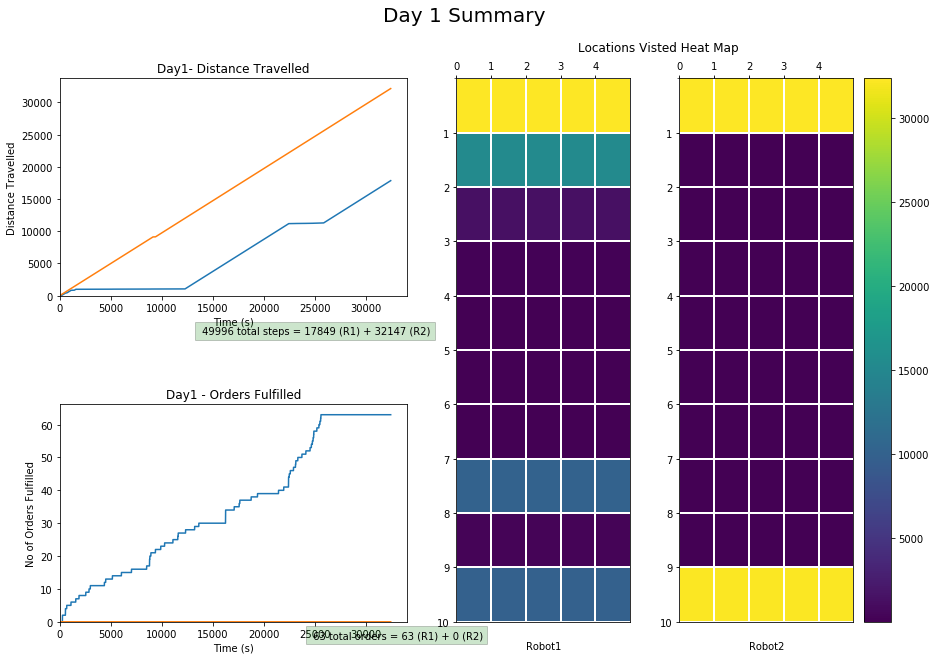

In [4]:
state = env.reset()
state = state.flatten()

day = 1
num_frames = 64800
batch_size = 32

losses = []
all_rewards = []

episode_reward = 0
epsilon = 0

# env.render()

distance1 = []
distance2 = []

fulfilled1 = []
fulfilled2 = []

heat1 = np.zeros((10,5))
heat2 = np.zeros((10,5))

loc1 = [0,1]
loc2 = [0,3]

for frame_idx in range(1, num_frames+1):

    action_1,action_2 = current_model.act(state, epsilon)

    next_state, reward, done, info = env.step([action_1,action_2])
    next_state=next_state.flatten()
    
#     env.render()
    
#     print("action_1: ", action_1, "action_2: ", action_2)
    
    if action_1 == 0:
        pass
    
    elif action_1 == 1:
        
        if loc1[0] + 1 > 4:
            pass
        else:
            loc1[0] = loc1[0] + 1
            
    elif action_1 == 2:
        
        if loc1[0] - 1 < 0:
            pass
        else:
            loc1[0] = loc1[0] - 1
            
    elif action_1 == 3:
        
        if loc1[1] + 1 > 9:
            pass
        else:
            loc1[1] = loc1[1] + 1
        
    elif action_1 == 4:
        
        if loc1[1] - 1 < 0:
            pass
        else:
            loc1[1] = loc1[1] - 1
    
    
    if action_2 == 0:
        pass
    
    elif action_2 == 1:
        
        if loc2[0] + 1 > 4:
            pass
        else:
            loc2[0] = loc2[0] + 1
            
    elif action_2 == 2:
        
        if loc2[0] - 1 < 0:
            pass
        else:
            loc2[0] = loc2[0] - 1
            
    elif action_2 == 3:
        
        if loc2[1] + 1 > 9:
            pass
        else:
            loc2[1] = loc2[1] + 1
            
    elif action_2 == 4:
        
        if loc2[1] - 1 < 0:
            pass
        else:
            loc2[1] = loc2[1] - 1
    
    
    #print("loc1: ", loc1, "loc2: ", loc2)
    
    state = next_state
    episode_reward += reward[0]+reward[1]
    
    
    distance1.append(info['distance'][0])
    distance2.append(info['distance'][1])

    fulfilled1.append(info['orders'][0])
    fulfilled2.append(info['orders'][1])

    heat1[loc1] +=1
    heat2[loc2] +=1
    

    if done:

        print("done")
        
        total_orders = fulfilled1[-1] + fulfilled2[-1]
        heat_maps = [np.flip(heat1,0),np.flip(heat2,0)]

        fig = plt.figure(figsize=(15, 10))

        fig.suptitle('Day ' + str(day) + ' Summary', size=20)
        gs = plt.GridSpec(2, 3, width_ratios=[1.6, 0.8, 1], hspace=0.5)


        ax1 = fig.add_subplot(gs[0,0])
        caption = " {} total steps = {} (R1) + {} (R2)".format(distance1[-1]+distance2[-1],distance1[-1],distance2[-1])

        ax1.set_title("Day" + str(day) + "- Distance Travelled")
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Distance Travelled")

        ax1.plot((distance1),label="robot-1")
        ax1.plot((distance2),label="robot-2")
        ax1.set_ylim(bottom=0)
        ax1.set_xlim(0)
        ax1.text(25000, -6000, caption, ha='center', bbox=dict(facecolor='g', alpha=0.2))


        ax2 = fig.add_subplot(gs[1,0])

        caption =" {} total orders = {} (R1) + {} (R2)".format(fulfilled1[-1]+fulfilled2[-1],fulfilled1[-1],fulfilled2[-1])

        ax2.set_title("Day" + str(day) + " - Orders Fulfilled")
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("No of Orders Fulfilled")

        # make the edge colors match the facecolors
        ax2.plot(fulfilled1,label="robot-1")
        ax2.plot(fulfilled2,label="robot-2")
        ax2.set_ylim(bottom=0)
        ax2.set_xlim(0)
        # center text
        ax2.text(33000, -5, caption, ha='center', bbox=dict(facecolor='g', alpha=0.2))

        ax3 = fig.add_subplot(gs[:, 1])
        ax3.pcolor(heat_maps[0])
        ax3.grid(color='w', linestyle='-', linewidth=2)
        ax3.set_xticks(np.arange(0,5,1))
        ax3.set_yticks(np.arange(0,10,1))

        # Labels for major ticks
        ax3.set_xticklabels(np.arange(0, 5, 1));
        ax3.set_yticklabels(np.arange(10, 0, -1));

        # Minor ticks
        ax3.set_xticks(np.arange(0, 5, 1), minor=True);
        ax3.set_yticks(np.arange(10, 0, -1), minor=True);

        # Gridlines based on minor ticks
        ax3.grid(which='minor', color='w', linestyle='-', linewidth=2)

        ax3.xaxis.tick_top()
        ax3.text(2, -0.5, "Robot1", size=10)
        ax3.text(3.5, 10.5, "Locations Visted Heat Map", size=12)


        ax4 = fig.add_subplot(gs[:, 2])
        im4 = ax4.pcolor(heat_maps[1])
        ax4.grid(color='w', linestyle='-', linewidth=2)
        ax4.set_xticks(np.arange(0,5,1))
        ax4.set_yticks(np.arange(0,10,1))

        # Labels for major ticks
        ax4.set_xticklabels(np.arange(0, 5, 1));
        ax4.set_yticklabels(np.arange(10, 0, -1));

        # Minor ticks
        ax4.set_xticks(np.arange(0, 5, 1), minor=True);
        ax4.set_yticks(np.arange(10, 0, -1), minor=True);

        ax4.xaxis.tick_top()
        ax4.text(2, -0.5, "Robot2", size=10)

        plt.colorbar(im4,ax=ax4)

        plt.savefig('Day'+str(day)+'_RL.png')
        
        state = env.reset()
        state = state.flatten()
        all_rewards.append(episode_reward)
        print("Episode Reward When Done: {}".format(episode_reward))
        episode_reward = 0

print("OUT OF LOOP")